<a href="https://colab.research.google.com/github/Kyle715-hk/EV-Adoption-Analysis-SDGs/blob/main/K_means_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded /content/IEA Global EV Data 2024 2025-05-14 11_53_51.csv Shape: (12654, 8)
Columns: ['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit', 'value']
Loaded /content/WorldBankIndicator_GDPperCapital.csv Shape: (261, 70)
Columns: ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', 'Unnamed: 69']
Loaded /content/WorldBankIndicator_urbanpopulation.csv Shape: (261, 70)
Columns: ['Country Name', 'Country Code', 'Indicator Name', 'Indicator 

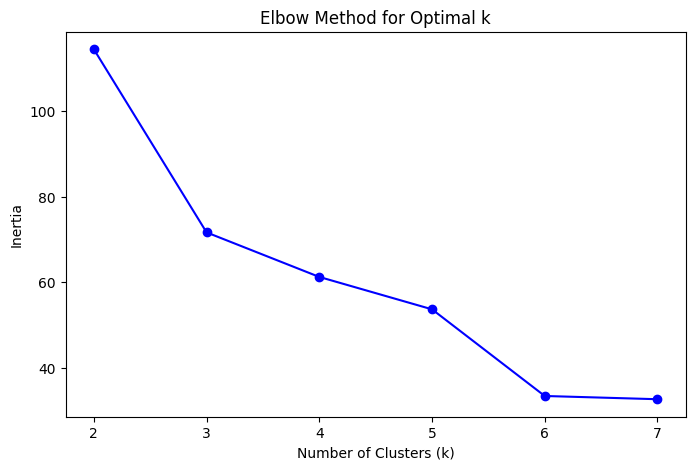

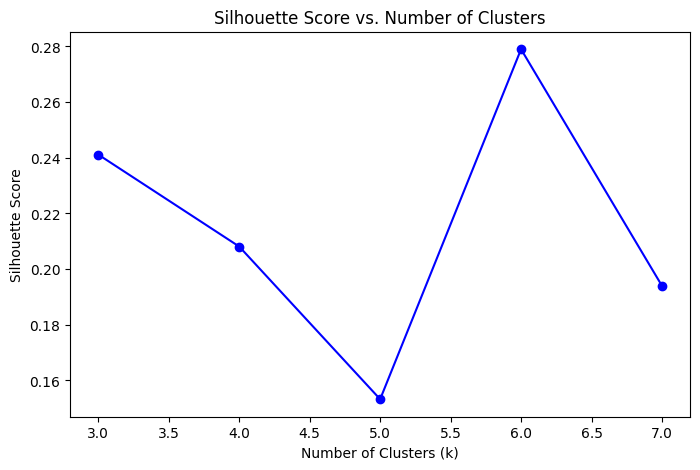


Cluster Summary (Mean Values):
    cluster  ev_sales_share      ev_stock  GDP per capita  \
0        0       16.750000  3.660200e+06    68556.319360   
1        1       12.850000  1.959590e+05    28084.942763   
2        2       38.000000  4.818000e+06    12614.061742   
3        3       93.000000  9.002900e+05    87925.094419   
4        4        9.110000  3.963029e+05    40706.856455   
5        5       44.333333  4.235398e+05    65955.671413   

   Urban population (% of total population)  manufacturing_employment  
0                                 80.531500                 15.002250  
1                                 62.928833                 16.462500  
2                                 64.570000                 29.065000  
3                                 83.995000                  7.046000  
4                                 85.179600                 10.627150  
5                                 88.096000                 10.977333  

Regions per Cluster:
    cluster         

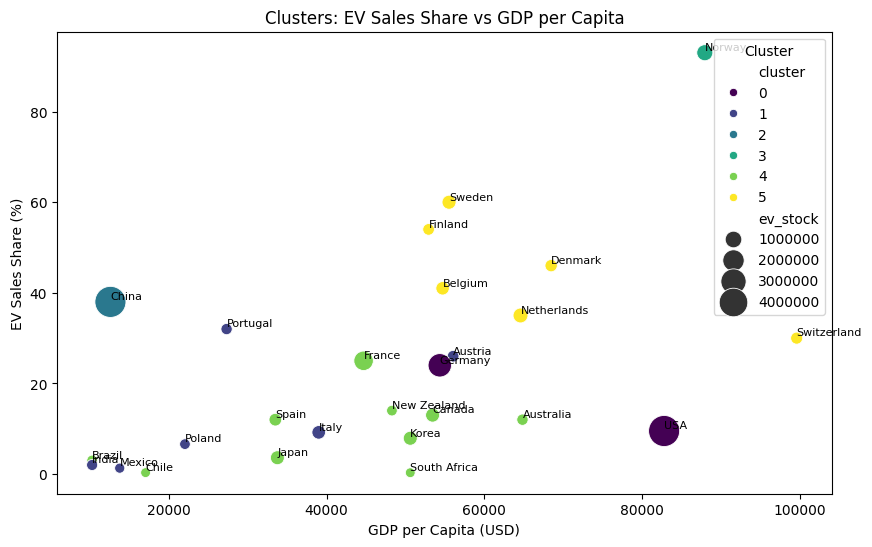

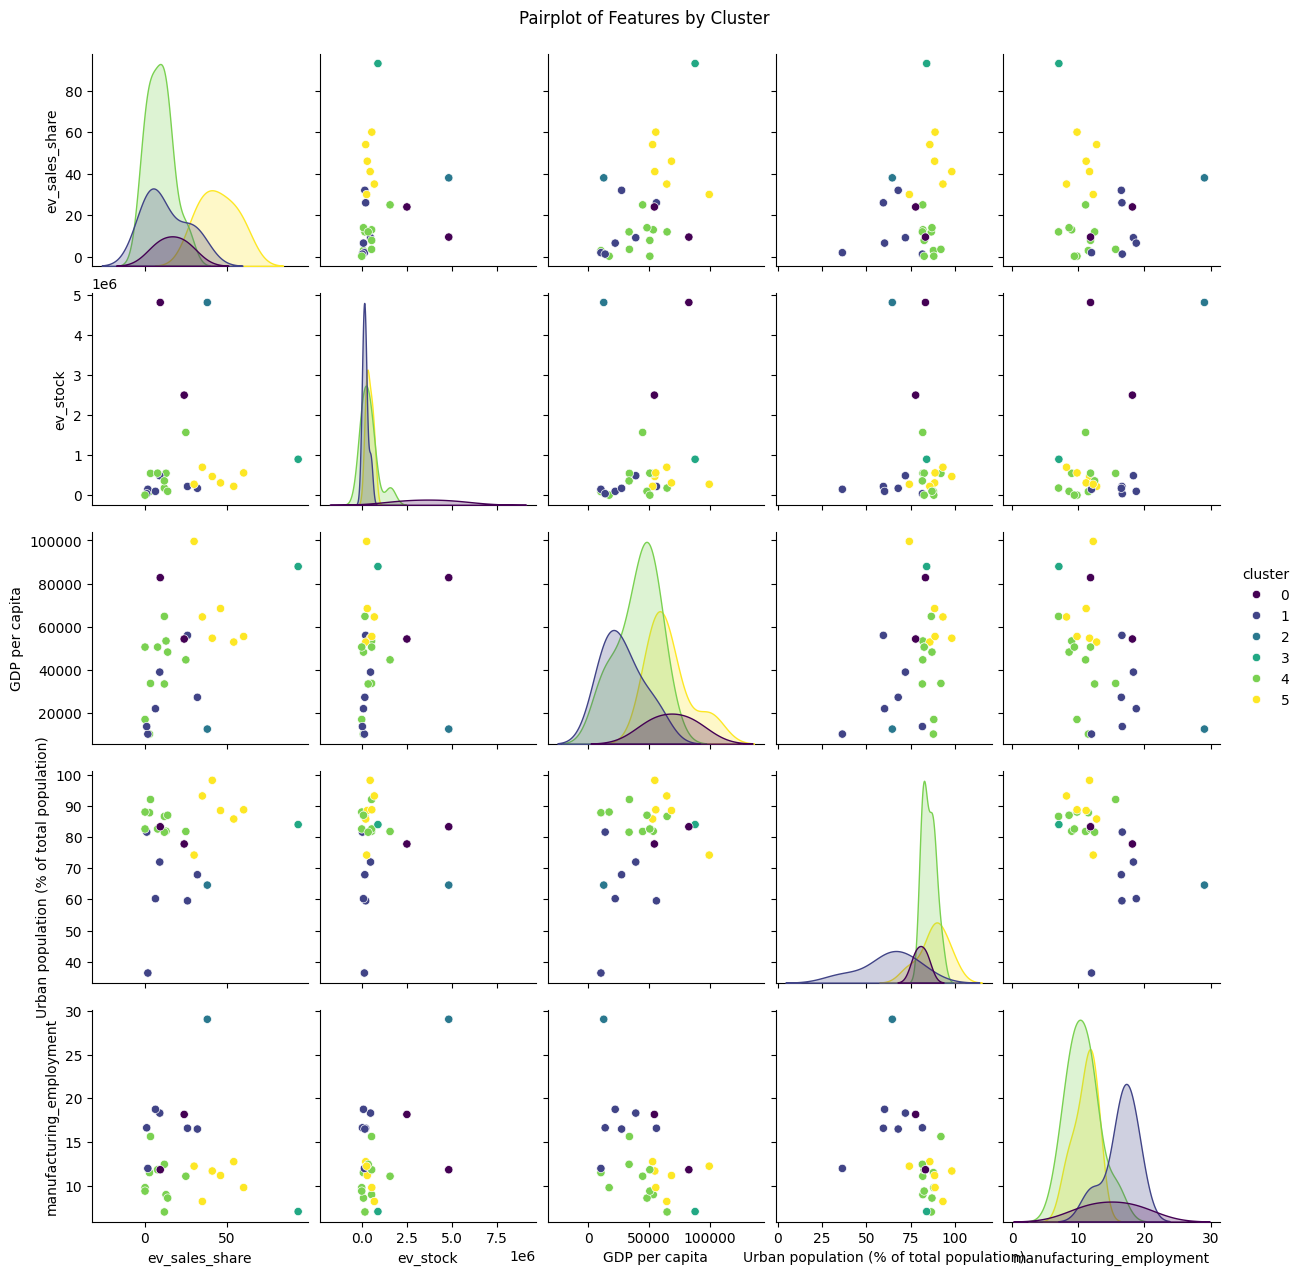

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats

# Function to load CSV
def load_csv(file_path, expected_columns=None, rename_map=None, skiprows=None, skipfooter=0):
    try:
        df = pd.read_csv(file_path, sep=',', encoding='utf-8', skiprows=skiprows, skipfooter=skipfooter, engine='python')
        print(f"Loaded {file_path} Shape:", df.shape)
        print(f"Columns:", df.columns.tolist())
        if expected_columns:
            missing_cols = [col for col in expected_columns if col not in df.columns]
            if missing_cols:
                print(f"Warning: Missing expected columns {missing_cols} in {file_path}")
        if rename_map:
            df = df.rename(columns=rename_map)
        return df
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        exit(1)
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None

# Region mapping
region_map = {
    'United States': 'USA',
    'Turkiye': 'Turkey',
    'South Korea': 'Korea',
    'Korea, Republic of': 'Korea',
    'Russian Federation': 'Russia',
    'United Kingdom': 'UK',
    'United Arab Emirates': 'UAE',
    'Czech Republic': 'Czechia',
    'Iran, Islamic Republic of': 'Iran',
    'Hong Kong, China': 'Hong Kong',
    'Taiwan, Province of China': 'Taiwan',
    'Syrian Arab Republic': 'Syria',
    'Viet Nam': 'Vietnam',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Congo, Democratic Republic of the': 'Democratic Republic of Congo',
    'Moldova, Republic of': 'Moldova',
    'Tanzania, United Republic of': 'Tanzania',
    'Lao People’s Democratic Republic': 'Laos',
    'Palestine, State of': 'Palestine',
    'Brunei Darussalam': 'Brunei',
    'Macao, China': 'Macao',
    'Sao Tome and Principe': 'Sao Tome and Principe',
    'Timor-Leste': 'Timor-Leste',
    'Côte d’Ivoire': 'Cote d’Ivoire',
    'Cabo Verde': 'Cape Verde',
    'Eswatini': 'Eswatini',
    'Micronesia (Federated States of)': 'Micronesia',
    'North Macedonia': 'North Macedonia',
    'Somalia': 'Somalia'
}

iea_regions = [
    'Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile', 'China', 'Denmark', 'Finland',
    'France', 'Germany', 'India', 'Indonesia', 'Italy', 'Japan', 'Korea', 'Mexico', 'Netherlands',
    'New Zealand', 'Norway', 'Poland', 'Portugal', 'South Africa', 'Spain', 'Sweden', 'Switzerland',
    'Thailand', 'Turkey', 'UK', 'USA'
]

# Load datasets
# IEA dataset
iea_data = load_csv(
    '/content/IEA Global EV Data 2024 2025-05-14 11_53_51.csv',
    expected_columns=['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit', 'value']
)

# World Bank GDP per capita
wb_gdp_data = load_csv(
    '/content/WorldBankIndicator_GDPperCapital.csv',
    skiprows=4,
    skipfooter=5
)
if wb_gdp_data is not None:
    year_columns = [col for col in wb_gdp_data.columns if col.isdigit()]
    wb_gdp_data = wb_gdp_data[['Country Name'] + year_columns]
    wb_gdp_data = wb_gdp_data.melt(
        id_vars=['Country Name'],
        value_vars=year_columns,
        var_name='year',
        value_name='GDP per capita'
    )
    wb_gdp_data = wb_gdp_data.rename(columns={'Country Name': 'region'})
    wb_gdp_data['year'] = wb_gdp_data['year'].astype(int)
    wb_gdp_data['region'] = wb_gdp_data['region'].replace(region_map)
    wb_gdp_data = wb_gdp_data[wb_gdp_data['region'].isin(iea_regions)]
    wb_gdp_data = wb_gdp_data[wb_gdp_data['year'] == 2023][['region', 'GDP per capita']]
else:
    print("Failed to load GDP data. Exiting.")
    exit(1)

# World Bank Urban Population
wb_urban_data = load_csv(
    '/content/WorldBankIndicator_urbanpopulation.csv',
    skiprows=4,
    skipfooter=5
)
if wb_urban_data is not None:
    year_columns = [col for col in wb_urban_data.columns if col.isdigit()]
    wb_urban_data = wb_urban_data[['Country Name'] + year_columns]
    wb_urban_data = wb_urban_data.melt(
        id_vars=['Country Name'],
        value_vars=year_columns,
        var_name='year',
        value_name='Urban population (% of total population)'
    )
    wb_urban_data = wb_urban_data.rename(columns={'Country Name': 'region'})
    wb_urban_data['year'] = wb_urban_data['year'].astype(int)
    wb_urban_data['region'] = wb_urban_data['region'].replace(region_map)
    wb_urban_data = wb_urban_data[wb_urban_data['region'].isin(iea_regions)]
    wb_urban_data = wb_urban_data[wb_urban_data['year'] == 2023][['region', 'Urban population (% of total population)']]
else:
    print("Failed to load Urban Population data. Exiting.")
    exit(1)

# SDG Manufacturing Employment
sdg_manuf_data = load_csv(
    '/content/SDG indicator 9.2.2 - Manufacturing employment as a proportion of total employment (%) 2025-05-13 13_24_54.csv',
    expected_columns=['ref_area.label', 'time', 'obs_value'],
    rename_map={'ref_area.label': 'region', 'time': 'year', 'obs_value': 'manufacturing_employment'}
)
non_country_regions = [
    'World excluding BRICS', 'G7', 'MENA', 'Arab League', 'CARICOM', 'European Union 27',
    'Arab States: Low income', 'APEC', 'World excluding India and China',
    'World: Lower-middle income excluding India', 'World: Upper-middle income excluding China'
]
sdg_manuf_data = sdg_manuf_data[~sdg_manuf_data['region'].isin(non_country_regions)]
sdg_manuf_data['region'] = sdg_manuf_data['region'].replace(region_map)
sdg_manuf_data = sdg_manuf_data[sdg_manuf_data['region'].isin(iea_regions)]
sdg_manuf_data = sdg_manuf_data[sdg_manuf_data['year'] == 2023][['region', 'manufacturing_employment']]

# Process IEA Data for 2023
iea_historical = iea_data[(iea_data['category'] == 'Historical') & (iea_data['year'] == 2023) & (iea_data['region'].isin(iea_regions))]

# EV Sales Share
ev_sales = iea_historical[
    (iea_historical['parameter'] == 'EV sales share') &
    (iea_historical['mode'] == 'Cars')
][['region', 'value']].rename(columns={'value': 'ev_sales_share'})

# EV Stock
ev_stock = iea_historical[
    (iea_historical['parameter'] == 'EV stock') &
    (iea_historical['mode'] == 'Cars') &
    (iea_historical['powertrain'].isin(['BEV', 'PHEV', 'FCEV']))
]
ev_stock_pivot = ev_stock.groupby('region')['value'].sum().reset_index().rename(columns={'value': 'ev_stock'})

# Charging Points
charging_points = iea_historical[
    (iea_historical['parameter'] == 'EV charging points') &
    (iea_historical['mode'].isin(['Publicly available fast', 'Publicly available slow']))
]
charging_points_pivot = charging_points.groupby('region')['value'].sum().reset_index().rename(columns={'value': 'charging_points'})

# Merge IEA Data
iea_processed = ev_sales.merge(
    ev_stock_pivot,
    on='region',
    how='left'
).merge(
    charging_points_pivot,
    on='region',
    how='left'
)

# Merge with World Bank and SDG Data
data = iea_processed.merge(
    wb_gdp_data,
    on='region',
    how='left'
).merge(
    wb_urban_data,
    on='region',
    how='left'
).merge(
    sdg_manuf_data,
    on='region',
    how='left'
)

print("Merged Data Shape:", data.shape)
print("Merged Data Columns:", data.columns.tolist())
print("Merged Data Head:\n", data.head())
print("Missing Values:\n", data.isna().sum())

# Select features for clustering
features = [
    'ev_sales_share',
    'ev_stock',
    'GDP per capita',
    'Urban population (% of total population)',
    'manufacturing_employment'
]

# Handle outliers with winsorizing
for col in ['ev_stock', 'charging_points', 'GDP per capita']:
    data[col] = mstats.winsorize(data[col], limits=[0.05, 0.05])

# Impute missing values
imputer = SimpleImputer(strategy='median')
data[features] = imputer.fit_transform(data[features])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[features])

# Determine optimal number of clusters
inertia = []
silhouette_scores = []
K = range(2, 8)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    if k > 1:
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K[1:], silhouette_scores[1:], 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

# Choose k (e.g., 4 based on elbow and silhouette)
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
cluster_summary = data.groupby('cluster')[features].mean().reset_index()
print("\nCluster Summary (Mean Values):\n", cluster_summary)

# Add region names to clusters
cluster_regions = data[['region', 'cluster']].groupby('cluster')['region'].apply(list).reset_index()
print("\nRegions per Cluster:\n", cluster_regions)

# Visualize clusters (example: ev_sales_share vs GDP per capita)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='GDP per capita',
    y='ev_sales_share',
    hue='cluster',
    size='ev_stock',
    sizes=(50, 500),
    data=data,
    palette='viridis'
)
for i, row in data.iterrows():
    plt.text(row['GDP per capita'], row['ev_sales_share'] + 0.5, row['region'], fontsize=8)
plt.title('Clusters: EV Sales Share vs GDP per Capita')
plt.xlabel('GDP per Capita (USD)')
plt.ylabel('EV Sales Share (%)')
plt.legend(title='Cluster')
plt.show()

# Pairplot for all features
sns.pairplot(data, vars=features, hue='cluster', palette='viridis')
plt.suptitle('Pairplot of Features by Cluster', y=1.02)
plt.show()